In [1]:
import numpy as np

def compute_homography(src, dst):
    # This function computes the homography from src to dst.
    #
    # Input:
    #     src: source points, shape (n, 2)
    #     dst: destination points, shape (n, 2)
    # Output:
    #     H: homography from source points to destination points, shape (3, 3)
    
    # Code here...
    
    A = np.zeros([2*src.shape[0], 9])
    for i in range(src.shape[0]):
        A[2*i, :] = np.array([src[i,0],src[i,1],1,0,0,0,
                              -dst[i,0]*src[i,0],-dst[i,0]*src[i,1],-dst[i,0]])
        A[2*i+1, :] = np.array([0,0,0,src[i,0],src[i,1],1,
                                -dst[i,1]*src[i,0],-dst[i,1]*src[i,1],-dst[i,1]])
    
    w, v = np.linalg.eig(np.dot(A.T, A))
    index = np.argmin(w)
    H = v[:, index].reshape([3,3])
    return H

In [2]:
import numpy as np

def apply_homography(src, H):
    # Applies a homography H onto the source points, src.
    #
    # Input:
    #     src: source points, shape (n, 2)
    #     H: homography from source points to destination points, shape (3, 3)
    # Output:
    #     dst: destination points, shape (n, 2)
    final = np.zeros_like(src)
    for i in range(len(src)):
        transform = np.append(src[i],[[1]],1)
        result = np.dot(H,transform.T)
        result /= result[2]
        final[i] = result.T[:,:2]
    return final

In [3]:
import numpy as np

def backward_warp_img(src_img, H, dst_img_size):
    # Input:
    #     src_img: source image, shape (m, n, 3)
    #     H: homography from destination to source image, shape (3, 3)
    #     dst_img_size: height and width of destination image, shape (2,)
    # Output:
    #     dst_img: destination image, shape (m, n, 3)
    shape = src_img.shape
    new_img = np.zeros((*dst_img_size,3))
    for i in range(dst_img_size[1]):
        for j in range(dst_img_size[0]):
            test_pt = apply_homography(np.matrix([i,j]),H)
            if 0<=test_pt[0,0]<shape[1] and 0<=test_pt[0,1]<shape[0]:
                new_img[j,i] = src_img[test_pt[0,1],test_pt[0,0]]
                
    return new_img

In [4]:
import cv2
import numpy as np

def genSIFTMatchPairs(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    pts1 = np.zeros((250,2))
    pts2 = np.zeros((250,2))
    for i in range(250):
        pts1[i,:] = kp1[matches[i].queryIdx].pt
        pts2[i,:] = kp2[matches[i].trainIdx].pt
    
    return pts1, pts2, matches[:250], kp1, kp2

In [5]:
import numpy as np
import random

def RANSAC(Xs, Xd, max_iter, eps):
    # Input:
    #     pts1: the first set of points, shape [n, 2]
    #     pts2: the second set of points matched to the first set, shape [n, 2]
    #     max_iter: max iteration number of RANSAC
    #     eps: tolerance of RANSAC
    # Output:
    #     inliers_id: the indices of matched pairs when using the homography given by RANSAC
    #     H: the homography, shape [3, 3]
    shape = Xs.shape
    maximum = [], None
    for i in range(max_iter):
        random_points = [random.randint(0,shape[0]-1) for i in range(4)]
        start_points = np.matrix([Xs[rand] for rand in random_points])
        end_points = np.matrix([Xd[rand] for rand in random_points])
        homography = compute_homography(start_points, end_points)

        # Evaluate the model
        result = apply_homography(np.matrix(Xs), homography)
        inliers = []
        for i in range(shape[0]):
            if result[i,0]-eps<Xd[i,0]<result[i,0]+eps and result[i,1]-eps<Xd[i,1]<result[i,1]+eps: 
                inliers.append(i)
        if len(inliers) > len(maximum[0]):
            maximum = inliers, homography

    return maximum[0],maximum[1]

In [6]:
import matplotlib.pyplot as plt
 
img1 = cv2.imread('new_img.png')
img2 = cv2.imread('images.png')
new_img = np.zeros((406,156,3))
shape = new_img.shape
for i in range(shape[0]):
    for j in range(shape[1]):
        try:
            new_img[i,j] = img2[i,j]
        except IndexError:
            new_img[i,j] = (0,0,0)
            
print(new_img.shape)
plt.imshow(new_img)

(406, 156, 3)


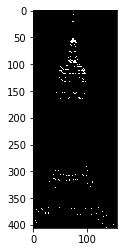

In [7]:
gray_1 = img1.astype(np.uint8)
gray_1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_1, cmap='gray')

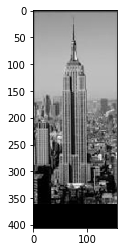

In [8]:
new_img = new_img.astype(np.uint8)
gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
#sift = cv2.xfeatures2d.SIFT_create()
#kp1, des1 = sift.detectAndCompute(new_img, None)

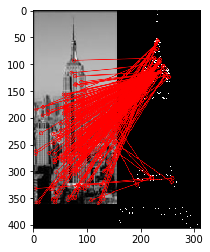

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(gray,gray_1)

matching_result = cv2.drawMatches(gray, kp1, gray_1, kp2, matches, None, flags=2, matchColor=(0,0,255))
plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

/home/pstance/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


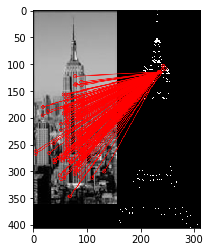

In [10]:
inliers_idx, H = RANSAC(pts1, pts2, 1500, 5)

new_matches = []
for i in range(len(inliers_idx)):
    new_matches.append(matches[inliers_idx[i]])

matching_result = cv2.drawMatches(gray, kp1, gray_1, kp2, new_matches, None, flags=2, matchColor=(0,0,255))
plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))


#write_output_img("test3.png", matching_result)

In [11]:
# a = backward_warp_img()